In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import kwant

import tinyarray

import lmfit as lmf

import scipy.linalg as lin

from tqdm import tqdm
import pickle

from scipy import stats

import warnings

In [2]:
import traceback
import warnings
import sys

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

In [3]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = 6,3.6
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams.update({'figure.autolayout': True})

In [4]:
tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])
tau_0 = tinyarray.array([[1, 0], [0, 1]])

def Lorentzian(eex, ee, gam):
    return (gam/np.pi)*(1/((eex-ee)**2 + gam**2))

def Fermi(eps, beta = 'inf'):
    if beta == 'inf':
        return int(eps<0)
    else:
        return 1/(1+np.exp(beta*eps))
    
Fibonacci_number = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657]
tau_approximant = [1, 2.0, 1.5, 1.6666666666666667, 1.6, 1.625, 1.6153846153846154, 1.619047619047619, 1.6176470588235294, 1.6181818181818182, 1.6179775280898876, 1.6180555555555556, 1.6180257510729614, 1.6180371352785146, 1.618032786885246, 1.618034447821682, 1.6180338134001253, 1.618034055727554, 1.6180339631667064, 1.6180339985218033, 1.618033985017358, 1.6180339901755971]

In [5]:
class Fibonacci_chains:
    def __init__(self):
        self.Fibonacci_cellar = {}
    
    def get_chain(self,n,j):
        N = Fibonacci_number[n]
        if j>=N:
            warnings.warn("phi greater than 2 pi. Using modulo 2 pi.")
            j = j%N
        try:
            chain = self.Fibonacci_cellar[(n,j)]
        except KeyError:

            tau = tau_approximant[n]
            phi = 2*np.pi*j/N
            chain = ["A" if np.sign(np.cos(2*np.pi*m*(1/tau) + phi) - np.cos(np.pi*(1/tau)))>=0 else "B" for m in range(N)]
            self.Fibonacci_cellar[(n,j)] = chain
        return chain

FCs = Fibonacci_chains()

In [6]:
class TBmodel:
    def __init__(self, LL, ts, us, vs):
        self.LL = LL
        self.a = 1
        self.ts, self.us, self.vs = ts, us, vs
        self.Delta = np.ones(self.LL, dtype = "complex") + 1j*np.resize([1,-1], self.LL)
        self.Pot = np.zeros(self.LL, dtype = "complex")

    def onsite(self, site, Delta, Pot):
        (x,y) = site.tag
        return (self.us[x]+Pot[x])*tau_z - self.vs[x]*Delta[x]*tau_x
    
    def hopping(self,site1,site2):
        (x2,y2) = site2.tag
        (x1,y1) = site1.tag
        return self.ts[x1]*tau_z*np.exp(1j*self.thetas[x1])
    
    def make_syst(self):
        self.syst = kwant.Builder()
        self.lat = kwant.lattice.square(self.a, norbs = 2)
        
        self.syst[(self.lat(x,0) for x in range(self.LL))] = self.onsite
        self.syst[((self.lat(x+1,0),self.lat(x,0)) for x in range(self.LL-1))] = self.hopping
        self.syst[((self.lat(0,0), self.lat(self.LL-1,0)))] = self.hopping
        
        self.fsyst = self.syst.finalized()
        return

    def solve(self,H):
        (evals, evecs) = lin.eigh(H)
    
        uvecs = evecs[::2]
        vvecs = evecs[1::2]
        
        return (evals[self.LL:],uvecs[:,self.LL:],vvecs[:,self.LL:])

    def iterate(self):
        def self_cons(H):
            (evals, uvecs, vvecs) = self.solve(H)
            self.evals, self.uvecs, self.vvecs = (evals, uvecs, vvecs)
            
            Delta = np.zeros(self.LL, dtype = "complex128")
            for ee, uvec, vvec in zip(evals, uvecs.T, vvecs.T):
                Delta += (1-2*Fermi(ee, beta = self.beta))*uvec*vvec.conjugate()
            
            occupancy = np.zeros(self.LL, dtype = "complex128")
            for ee, uvec, vvec in zip(evals, uvecs.T, vvecs.T):
                    occupancy += Fermi(ee, beta = self.beta)*2*np.abs(vvec)**2 + (1-Fermi(ee))*2*np.abs(uvec)**2
            
            Pot = 1/2*self.vs*occupancy
            Pot = Pot + 0.0001*np.ones(len(Pot))

            return (Delta, Pot)
        
        err_Delta = np.ones(1)
        cc = 0
        
        fig, ax1 = plt.subplots()
        fig, ax2 = plt.subplots()
        
        
        while any([abs(Del)>10**(-10) and (abs(err)/abs(Del))>0.001 for err,Del in zip(err_Delta, self.Delta)]):
#         while cc<5:        
            H = self.fsyst.hamiltonian_submatrix(params = dict(Delta = self.Delta, Pot = self.Pot))
            newDelta, newPot = self_cons(H)
            newDelta = newDelta/2 + self.Delta/2
            err_Delta = np.abs(newDelta.real - self.Delta.real)
            
            ax1.plot(newDelta.real)
            ax2.plot(newDelta.imag)
#             ax2.plot(newPot.real)
#             ax2.plot(newPot.imag, "k")
            ax1.set_ylabel("Re($\\Delta$)")
            ax2.set_ylabel("Im($\\Delta$)")
            
            cc += 1    
            self.Delta, self.Pot = newDelta, newPot
        
        print("Convergence took {} iterations".format(cc))
        
        self.H = H
        return self.Delta, self.Pot
        
    
    def get_DOS(self, gam = None, Num_es = 1000):
        emax = np.max(np.abs(self.evals))
        
        if gam == None:
            gam = 2*emax/self.LL
            
        eex = np.linspace(-1.2*emax,1.2*emax, Num_es)
        DOSu = np.zeros(eex.shape)
        DOSv = np.zeros(eex.shape)
        
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            if ee>0:
                DOSu += np.linalg.norm(uvec)**2*Lorentzian(eex,ee,gam) 
                DOSv += np.linalg.norm(vvec)**2*Lorentzian(eex,-ee,gam)
                
        self.DOS = (DOSu + DOSv)/self.LL
        return  self.DOS , eex
    
    def get_LDOS(self, gam = None, Num_es = 1000):
        emax = np.max(np.abs(self.evals))
        
        if gam == None:
            gam = 2*emax/self.LL
            
        eex = np.linspace(-1.2*emax,1.2*emax, Num_es)
        DOSu = np.zeros((self.uvecs.shape[0],eex.shape[0]))
        DOSv = np.zeros(DOSu.shape)
        
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            if ee>0:
                DOSu += (np.abs(uvec)**2)[:,np.newaxis]*Lorentzian(eex,ee,gam)
                DOSv += (np.abs(vvec)**2)[:,np.newaxis]*Lorentzian(eex,-ee,gam)      
            
        self.LDOS = (DOSu + DOSv)/self.LL
        return  self.LDOS,eex
    
    def get_ham(self,inds):
        if inds == 'full':
            return self.fsyst.hamiltonian_submatrix(params = dict(Delta = self.Delta, Pot = self.Pot))
        else:
            return self.fsyst.hamiltonian(*inds, params = dict(Delta = self.Delta, Pot = self.Pot))
        
        
        

In [7]:
class simple_ring(TBmodel):
    """
    Wrapper around TBmodel. Will generate a 1D tight-binding model with the parameters provided by chain.
    beta is the inverse temperature. use beta = "inf" for 0T.
    """
    def __init__(self, chain, beta = "inf"):
        self.chain = chain
        self.NN = chain["N"]
        self.beta = beta
        self.thetas = np.zeros(self.NN)

        
        ts = np.array(chain["t"])
        us = np.array(chain["u"])
        vs = np.array(chain["v"])
        
        TBmodel.__init__(self, self.NN, ts, us, vs)

        self.make_syst()
        
    def add_hopping_phases(self, ls, A):
        self.ls = np.array(ls)
        self.A = A
        self.thetas = self.ls*self.A
        
    def add_hopping_phases2(self, ls, A):
        self.ls = np.array(ls)
        self.A = A
        self.thetas = np.zeros(len(self.ls))
        self.thetas[0] = self.A*np.sum(self.ls)
        
    
    def get_current_para2(self):
        Paramagnetic_current_contributions = [];
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            u_term = uvec.conjugate()*np.roll(uvec,-1)*Fermi(ee, beta = self.beta)
            v_term = vvec*np.roll(vvec.conjugate(),-1)*(1-Fermi(ee, beta = self.beta))
            Paramagnetic_current_contributions.append(
            (1/(2*self.NN))*2*self.ls*self.ts*np.imag(np.exp(1j*self.thetas)*(u_term + v_term))
            )
        return np.array(Paramagnetic_current_contributions)
    
    def get_current_dia2(self):
        Diamagnetic_current_contributions = [];
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            u_term = uvec.conjugate()*np.roll(uvec,-1)*Fermi(ee, beta = self.beta)
            v_term = vvec*np.roll(vvec.conjugate(),-1)*(1-Fermi(ee, beta = self.beta))
            Diamagnetic_current_contributions.append(
            (1/(2*self.NN))*2*self.A*(self.ls**2)*self.ts*np.real(np.exp(1j*self.thetas)*(u_term + v_term))
            )
        return np.array(Diamagnetic_current_contributions)
    
    def get_current_para3(self):
        Paramagnetic_current_contributions = [];
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            u_term = uvec.conjugate()*np.roll(uvec,-1)*Fermi(ee, beta = self.beta)
            v_term = vvec*np.roll(vvec.conjugate(),-1)*(1-Fermi(ee, beta = self.beta))
            Paramagnetic_current_contributions.append(
            (1/(2*self.NN))*2*self.ts*np.imag(1j*self.thetas*(u_term + v_term))
            )
        return np.array(Paramagnetic_current_contributions)
    
    def get_current_dia3(self):
        Diamagnetic_current_contributions = [];
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            u_term = uvec.conjugate()*np.roll(uvec,-1)*Fermi(ee, beta = self.beta)
            v_term = vvec*np.roll(vvec.conjugate(),-1)*(1-Fermi(ee, beta = self.beta))
            Diamagnetic_current_contributions.append(
            (1/(2*self.NN))*2*self.A*self.ts*np.real((u_term + v_term))
            )
        return np.array(Diamagnetic_current_contributions)
            
        

In [8]:
def chainFC(n = 3, t=-1, w = 0.1, phi = 0, u = 0, v = 0, wu = 0, wv = 0, PBC = True, phase = 0):
    """
    Generates the hoppings, the on-site potentials, and the BCS attraction terms for a chain of length Fibonacci_number[n]
    The ts modulate according to the Fibonacci word with tA-tB = w and phi = phi. On-site potential and BCS attraction 
    is drawn from the uniform distribution u±wu and v±wv respectively. PBC = True will use periodic boundary conditions, 
    while PBC=False will use open boundary conditions.
    """
    L = Fibonacci_number[n]
    tau = tau_approximant[n]
    FC = FCs.get_chain(n,phi)
    
    wa = 2*w/(1+tau)
    wb = tau*wa

    ts = [1-wa if letter =="A" else 1+wb for letter in FC]
    ts[0] = ts[0]*np.exp(1j*phase)
    
    if PBC:
        chain = {
            "N": L,
            "t": -np.array(ts),
            "u" : u - wu/2 + wu*np.random.rand(L),
            "v" : v - wv/2 + wv*np.random.rand(L)
        }
        
    else:
        chain = {
            "N": L+1,
            "t": -np.concatenate((np.zeros(1),np.array(ts))),
            "u" : u - wu/2 + wu*np.random.rand(L+1),
            "v" : v - wv/2 + wv*np.random.rand(L+1)
        }
        
    return chain

In [9]:
def get_staircase(seq):
    walker = np.array([0,0])
    staircase = [np.array([0,0])]
    for letter in seq:
        if letter == "A":
            step = walker + np.array([1,0])
        else:
            step = walker + np.array([0,1])
        staircase.append(step)
        walker = step
    return staircase

def get_ordering(n, phi):
    seq = FCs.get_chain(n,phi)
    staircase = get_staircase(seq)
    alpha = np.arctan(1/tau_approximant[n-1])
    perp = np.array([-np.sin(alpha),np.cos(alpha)])
    perpendicular_components = [np.dot(perp,step) for step in staircase]
    ordering = np.argsort(perpendicular_components)
    ordering = np.hstack((ordering[Fibonacci_number[n-2]:],ordering[:Fibonacci_number[n-2]]))
    return np.mod(ordering, Fibonacci_number[n])

In [10]:
class Fibonacci_sequence:
    def __init__(self, n, phi):
        self.sequence = FCs.get_chain(n, phi)
        self.n = n
        self.phi = phi
        
    def get_staircase(self):
        seq = self.sequence
        walker = np.array([0,0])
        staircase = [np.array([0,0])]
        for letter in seq:
            if letter == "A":
                step = walker + np.array([1,0])
            else:
                step = walker + np.array([0,1])
            staircase.append(step)
            walker = step
        return staircase
    
    def get_ordering(self):
        staircase = self.get_staircase()
        alpha = np.arctan(1/tau_approximant[self.n-1])
        perp = np.array([-np.sin(alpha),np.cos(alpha)])
        perpendicular_components = [np.dot(perp,step) for step in staircase]
        ordering = np.argsort(perpendicular_components)
        ordering = np.hstack((ordering[Fibonacci_number[self.n-2]:],ordering[:Fibonacci_number[self.n-2]]))
        self.perp_ordering = np.mod(ordering, Fibonacci_number[self.n])
        return self.perp_ordering
        
  

## Test: complex initial Delta

In [11]:
# parameters
beta = 'inf'
n = 8
phi = 0
v = -1.5
A = 0

In [12]:
# Inital Delta is real and positive
chain1 = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0,PBC = True, phase = 0)
Model1 = simple_ring(chain1, beta = beta)
ls = np.ones(Model1.NN)
Model1.add_hopping_phases(ls, A)
Model1.Delta = np.random.rand(Model1.NN)

Convergence took 43 iterations


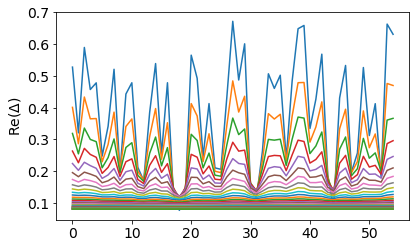

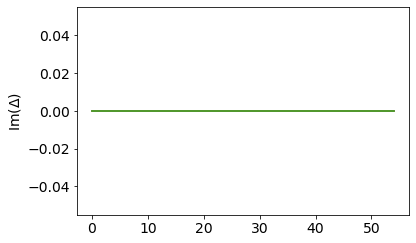

In [13]:
Model1.iterate();

In [14]:
print(np.abs(Model1.Delta))
np.abs(Model1.Delta.mean())

[0.08118903 0.08118732 0.08118686 0.08118464 0.08118365 0.08118105
 0.08117969 0.08117693 0.0811754  0.0811727  0.0811712  0.08116874
 0.08116745 0.08116545 0.08116453 0.08116311 0.08116267 0.08116197
 0.08116213 0.08116223 0.08116299 0.0811638  0.081165   0.08116634
 0.0811678  0.08116952 0.08117109 0.08117299 0.08117447 0.08117641
 0.08117773 0.0811797  0.08118089 0.08118285 0.08118381 0.08118562
 0.08118619 0.0811877  0.08118779 0.08118891 0.08118851 0.08118931
 0.0811886  0.08118928 0.08118848 0.08118926 0.08118854 0.08118947
 0.08118885 0.08118987 0.08118926 0.0811902  0.08118942 0.08119007
 0.08118889]


0.08117884321194536

In [15]:
# inital Delta is complex
# Inital Delta is real and positive
chain2 = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0,PBC = True, phase = 0)
Model2 = simple_ring(chain2, beta = beta)
ls = np.ones(Model2.NN)
Model2.add_hopping_phases(ls, A)
Model2.Delta = np.random.rand(Model2.NN) + 1j*np.random.rand(Model2.NN)

Convergence took 42 iterations


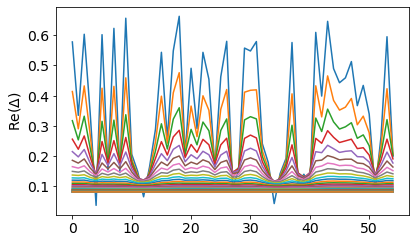

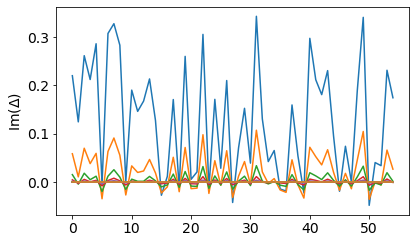

In [16]:
Model2.iterate();

In [17]:
print(np.abs(Model2.Delta))
np.abs(Model2.Delta.mean())

[0.08122369 0.0812232  0.08122171 0.08122091 0.08121942 0.08121851
 0.0812172  0.08121634 0.08121539 0.08121476 0.08121437 0.08121418
 0.08121454 0.08121489 0.08121594 0.08121658 0.08121793 0.08121844
 0.08121965 0.08121965 0.08122045 0.08121978 0.08122006 0.0812187
 0.0812185  0.08121658 0.08121605 0.08121374 0.08121307 0.08121062
 0.08121001 0.08120765 0.08120737 0.08120549 0.08120599 0.08120503
 0.08120659 0.08120667 0.08120922 0.08121017 0.08121339 0.08121482
 0.08121817 0.08121949 0.0812224  0.08122317 0.08122532 0.08122539
 0.08122675 0.08122622 0.08122693 0.08122601 0.08122628 0.08122514
 0.08122502]


0.08121715513059778

# Test - currents

In [ ]:
n = 11
phi = 0
v = -1.5
Models = []
for beta in betas:
    chain = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0,PBC = True, phase = 0)
    Model = simple_ring(chain, beta = beta)
    
    ls = np.ones(Model.NN)
    A = ((0*2 + 0.1)*np.pi)/(Model.NN)
    Model.add_hopping_phases2(ls, A)
    
    Model.iterate()
    Models.append(Model)

In [ ]:
fig, axes = plt.subplots(3, sharex = True, figsize = (8,9))
ax1, ax2, ax3 = axes
ax1.plot(Ts, [np.average(Model.Delta) for Model in Models],"C0", label = "$\\Delta$")

ax2.plot(Ts, [np.sum(Model.get_current_para2())for Model in Models],"C2", label ="Para")

ax3.plot(Ts, [np.sum(Model.get_current_dia2())for Model in Models], "C1", label = "Dia")

ax1.legend(loc = "upper left")
ax2.legend()
ax3.legend()

ax3.set_xlabel("Temperature")

totalPhase = (Model.NN*A)

ax1.set_title("A = {:.2g}, Total phase = {:.1f}$\\pi$, effective phase = {:.1f}$\\pi$".format(A, totalPhase/np.pi, (totalPhase%(2*np.pi))/np.pi))

# plt.savefig("temp2pi.png")

In [ ]:
n = 12
phi = 0
v = -2.25
Models = []
for beta in betas:
    chain = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0,PBC = True, phase = 0)
    Model = simple_ring(chain, beta = beta)
    
    ls = np.ones(Model.NN)
    A = ((0*2 + 0.2)*np.pi)/(Model.NN)
    Model.add_hopping_phases(ls, A)
    
    Model.iterate()
    Models.append(Model)

In [ ]:
fig, axes = plt.subplots(3, sharex = True, figsize = (8,9))
ax1, ax2, ax3 = axes
ax1.plot(Ts, [np.average(Model.Delta) for Model in Models],"C0", label = "$\\Delta$")

ax2.plot(Ts, [np.sum(Model.get_current_para2())for Model in Models],"C2", label ="Para")

ax3.plot(Ts, [np.sum(Model.get_current_dia2())for Model in Models], "C1", label = "Dia")

ax1.legend(loc = "upper left")
ax2.legend()
ax3.legend()

ax3.set_xlabel("Temperature")

totalPhase = (Model.NN*A)

ax1.set_title("A = {:.2g}, Total phase = {:.1f}$\\pi$, effective phase = {:.1f}$\\pi$".format(A, totalPhase/np.pi, (totalPhase%(2*np.pi))/np.pi))

# plt.savefig("temp2pi.png")

### Currents + all phases at once

In [503]:
Ts = np.linspace(0, 0.4, 15)
betas = ['inf'] + list(1/Ts[1:])

Convergence took 13 iterations
Convergence took 13 iterations
Convergence took 13 iterations
Convergence took 14 iterations
Convergence took 14 iterations
Convergence took 16 iterations
Convergence took 19 iterations
Convergence took 24 iterations
Convergence took 34 iterations
Convergence took 72 iterations


  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _r

Convergence took 353 iterations


  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _r

Convergence took 266 iterations


  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _r

Convergence took 211 iterations


  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _r

Convergence took 169 iterations


  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _r

Convergence took 139 iterations


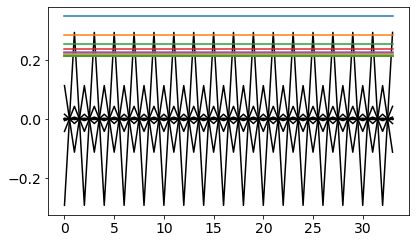

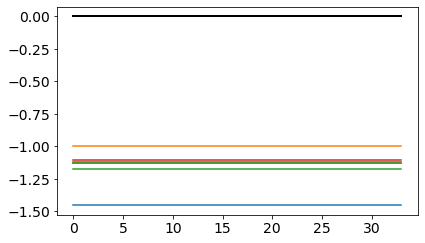

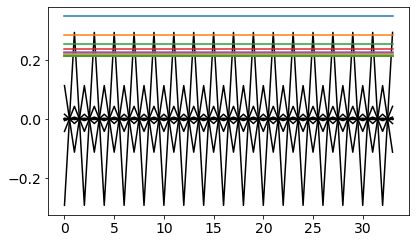

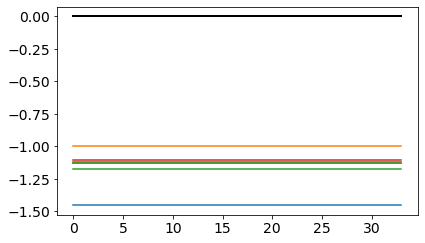

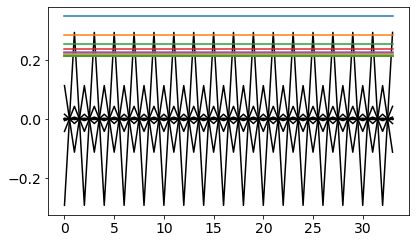

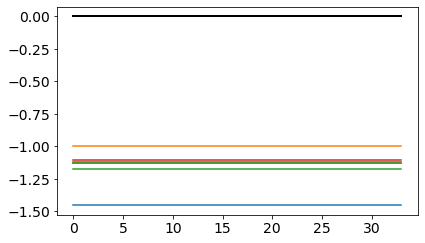

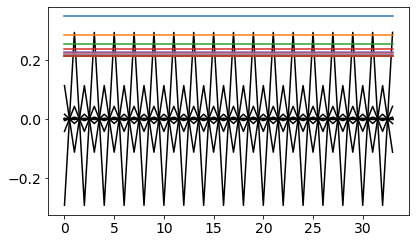

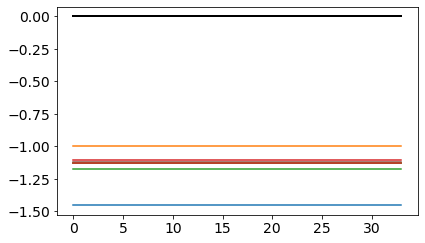

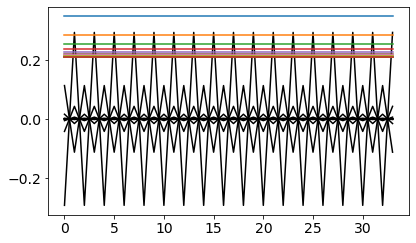

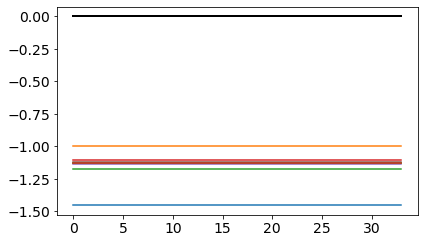

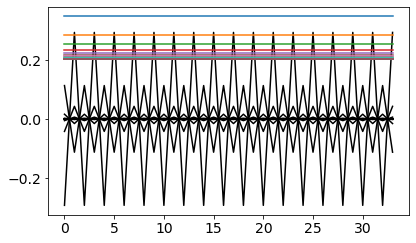

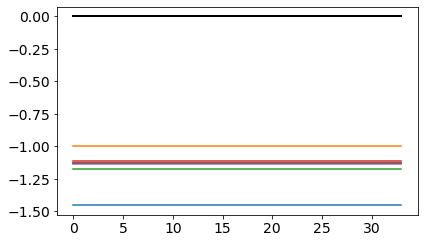

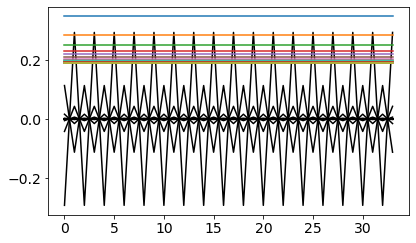

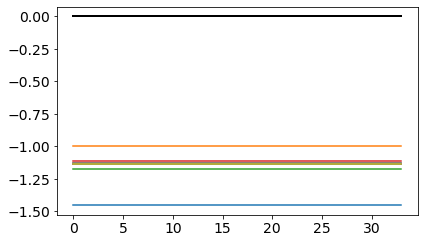

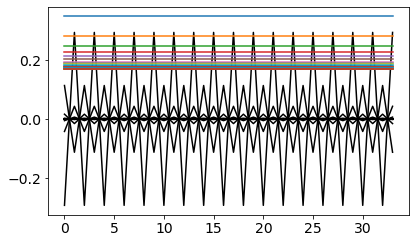

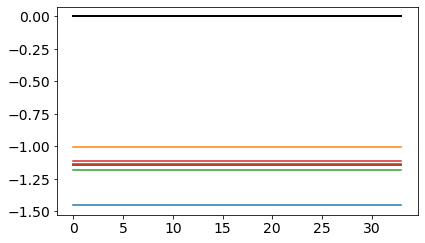

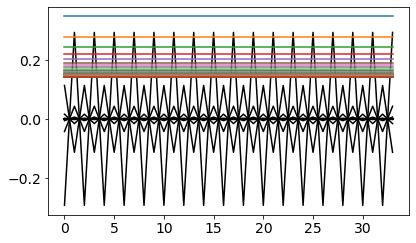

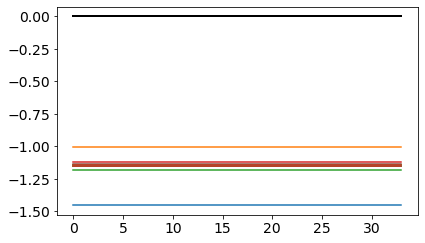

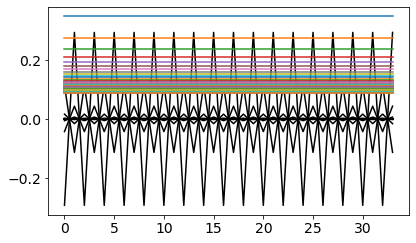

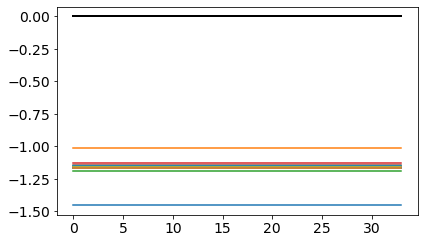

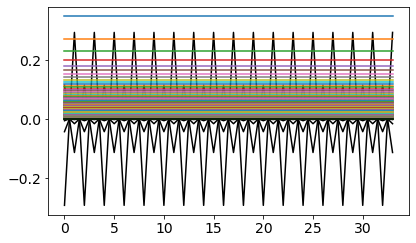

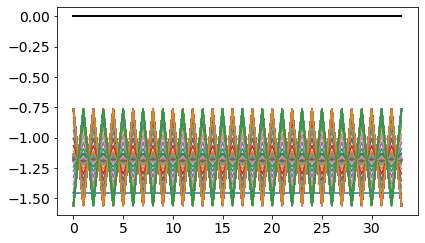

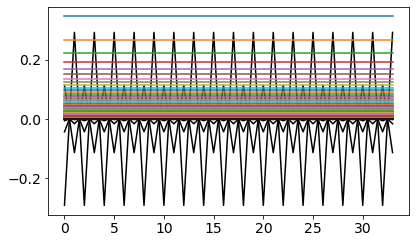

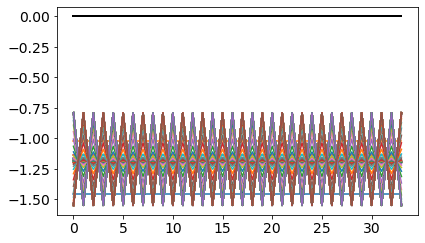

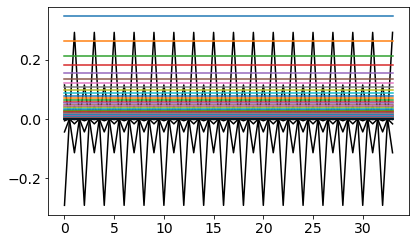

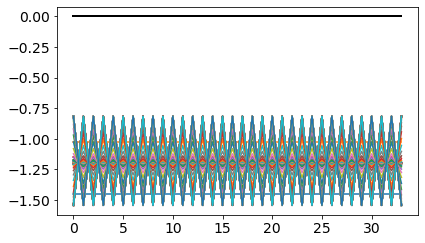

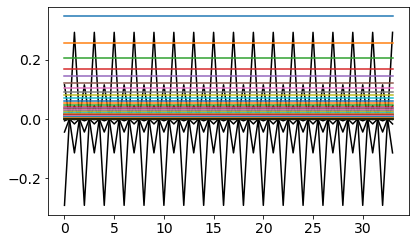

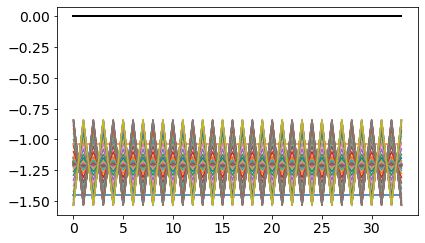

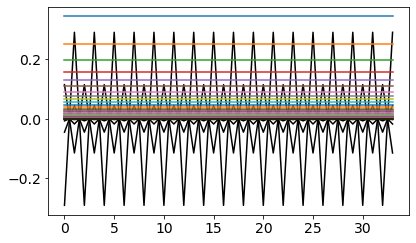

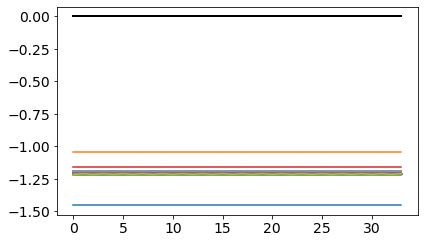

In [504]:
n = 7
phi = 0
v = -2.25
Models = []
for beta in betas:
    if beta is float and beta < betas[12]:
        v = 0
    chain = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0,PBC = True, phase = 0)
    Model = simple_ring(chain, beta = beta)

    ls = np.ones(Model.NN)
    A = ((0*2 + 0.1)*np.pi)/(Model.NN)
    Model.add_hopping_phases2(ls, A)

    Model.iterate()
    Models.append(Model)

  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _r

Text(0.5, 1.0, 'A = 0.0092, Total phase = 0.1$\\pi$, effective phase = 0.1$\\pi$')

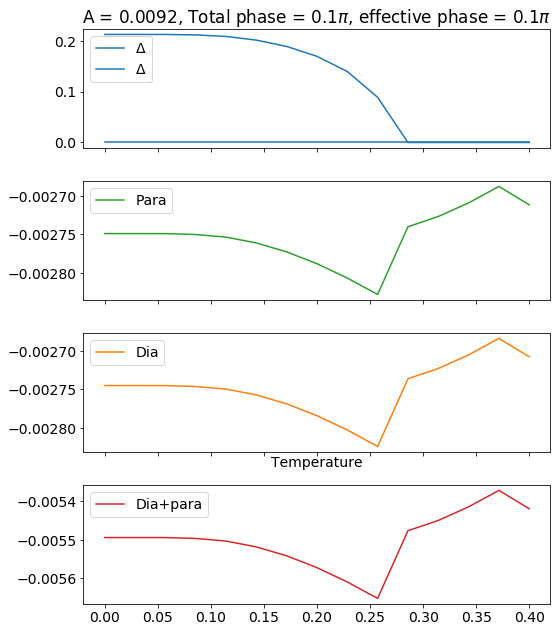

In [508]:
fig, axes = plt.subplots(4, sharex = True, figsize = (8,9))
ax1, ax2, ax3, ax4 = axes
ax1.plot(Ts, [np.average(Model.Delta.real) for Model in Models],"C0", label = "$\\Delta$")
ax1.plot(Ts, [np.average(Model.Delta.imag) for Model in Models],"C0", label = "$\\Delta$")

ax2.plot(Ts, [np.sum(Model.get_current_para3())for Model in Models],"C2", label ="Para")

ax3.plot(Ts, [np.sum(Model.get_current_dia3())for Model in Models], "C1", label = "Dia")

ax4.plot(Ts, [np.sum(Model.get_current_dia3()) + np.sum(Model.get_current_para3()) for Model in Models], "C3", label = "Dia+para")

ax1.legend(loc = "upper left")
ax2.legend()
ax3.legend()
ax4.legend()

ax3.set_xlabel("Temperature")

totalPhase = (Model.NN*A)

ax1.set_title("A = {:.2g}, Total phase = {:.1f}$\\pi$, effective phase = {:.1f}$\\pi$".format(A, totalPhase/np.pi, (totalPhase%(2*np.pi))/np.pi))

# plt.savefig("temp2pi.png")

Convergence took 13 iterations
Convergence took 13 iterations
Convergence took 13 iterations
Convergence took 14 iterations
Convergence took 14 iterations
Convergence took 16 iterations
Convergence took 19 iterations
Convergence took 24 iterations
Convergence took 34 iterations
Convergence took 72 iterations


  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _r

Convergence took 533 iterations


  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _r

Convergence took 314 iterations


  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _r

Convergence took 223 iterations


  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _r

Convergence took 172 iterations


  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _r

Convergence took 139 iterations


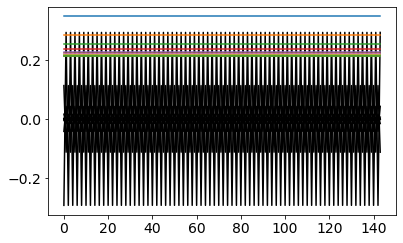

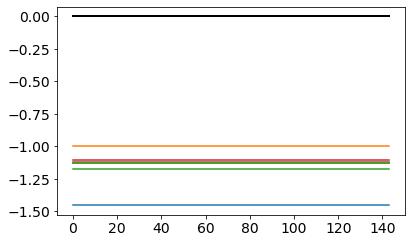

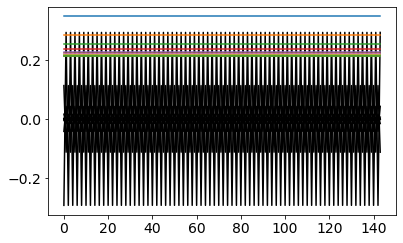

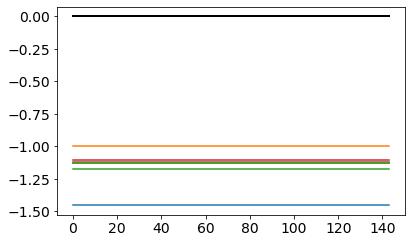

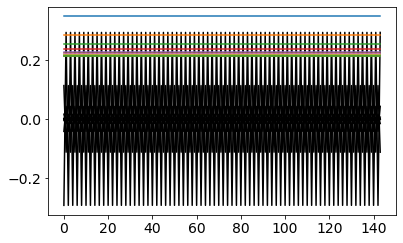

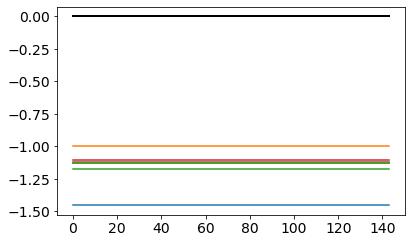

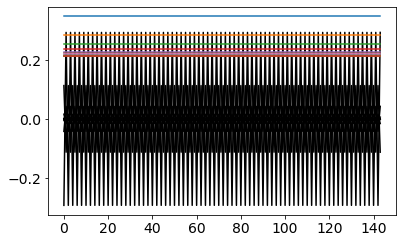

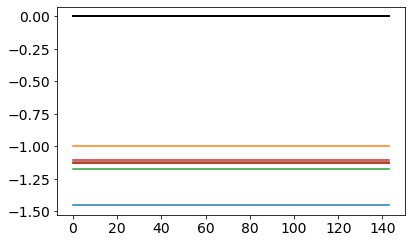

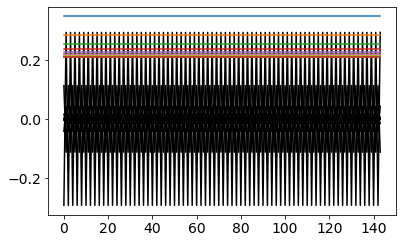

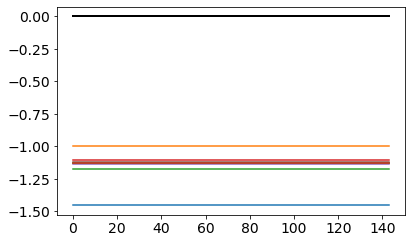

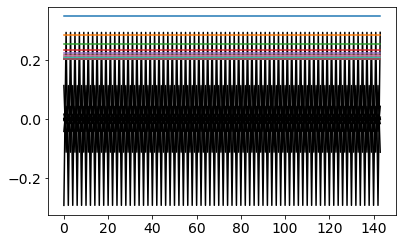

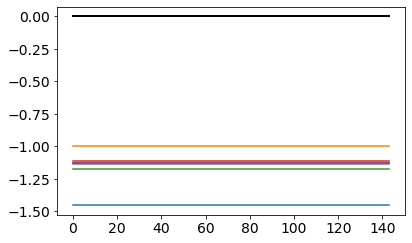

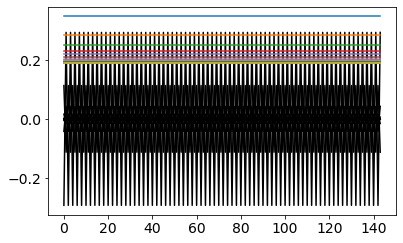

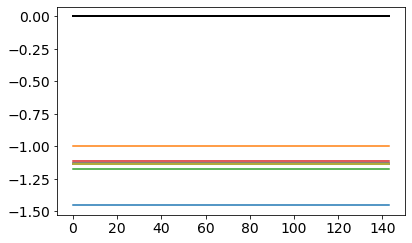

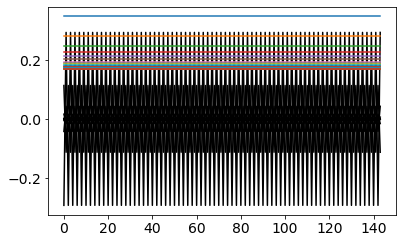

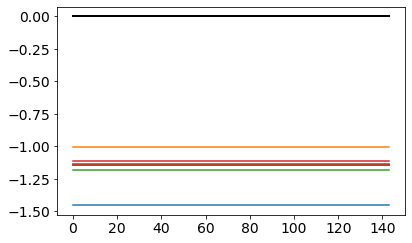

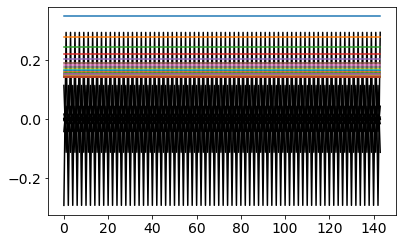

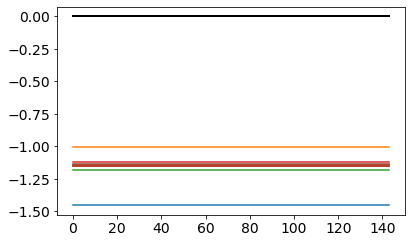

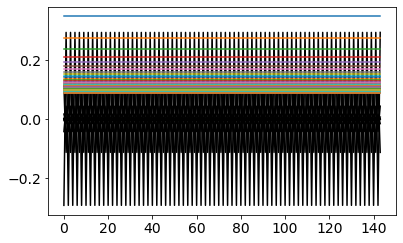

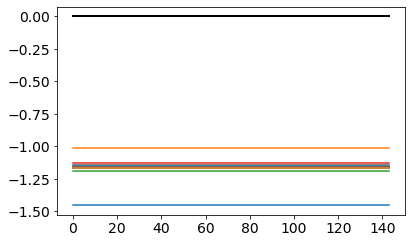

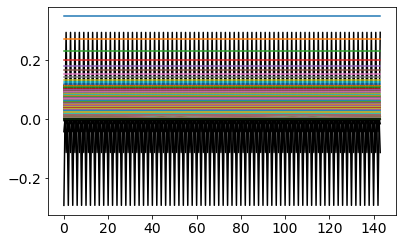

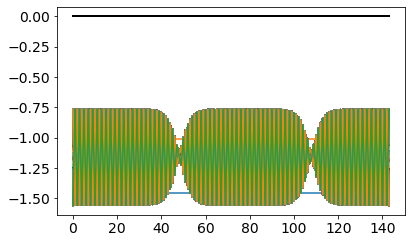

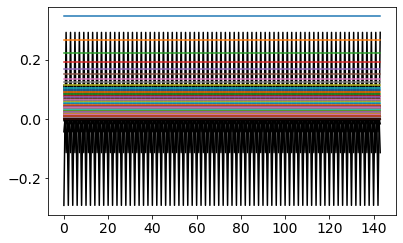

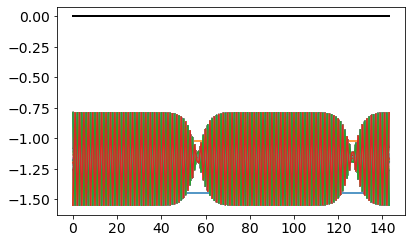

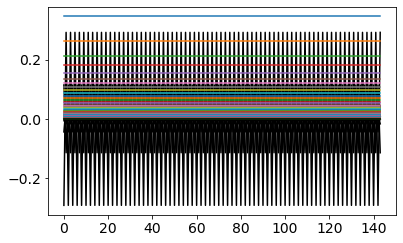

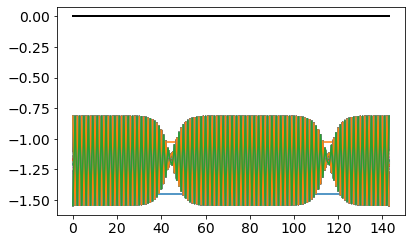

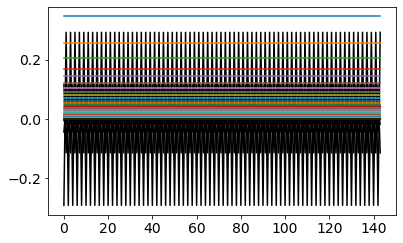

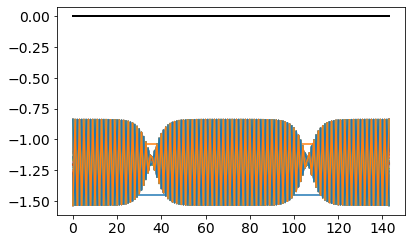

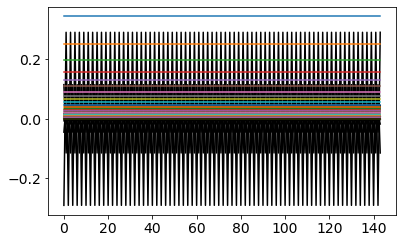

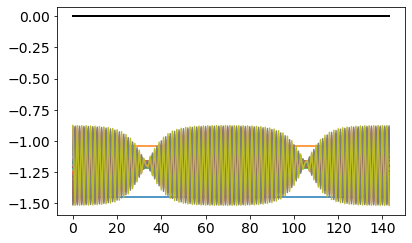

In [510]:
n = 10
phi = 0
v = -2.25
Models = []
for beta in betas:
    if beta is float and beta < betas[14]:
        v = 0
    chain = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0,PBC = True, phase = 0)
    Model = simple_ring(chain, beta = beta)

    ls = np.ones(Model.NN)
    A = ((0*2 + 0.1)*np.pi)/(Model.NN)
    Model.add_hopping_phases(ls, A)

    Model.iterate()
    Models.append(Model)

  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _r

  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _r

Text(0.5, 1.0, 'A = 0.0022, Total phase = 0.1$\\pi$, effective phase = 0.1$\\pi$')

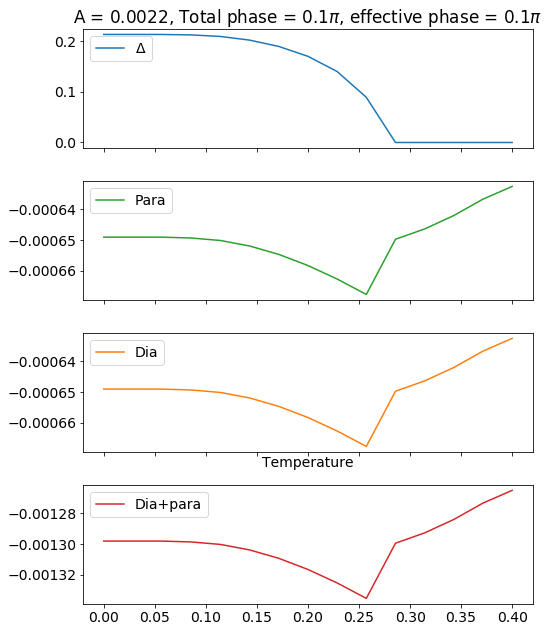

In [511]:
fig, axes = plt.subplots(4, sharex = True, figsize = (8,9))
ax1, ax2, ax3, ax4 = axes
ax1.plot(Ts, [np.average(Model.Delta) for Model in Models],"C0", label = "$\\Delta$")

ax2.plot(Ts, [np.sum(Model.get_current_para3())for Model in Models],"C2", label ="Para")

ax3.plot(Ts, [np.sum(Model.get_current_dia3())for Model in Models], "C1", label = "Dia")

ax4.plot(Ts, [np.sum(Model.get_current_dia3()) + np.sum(Model.get_current_para3()) for Model in Models], "C3", label = "Dia+para")

ax1.legend(loc = "upper left")
ax2.legend()
ax3.legend()
ax4.legend()

ax3.set_xlabel("Temperature")

totalPhase = (Model.NN*A)

ax1.set_title("A = {:.2g}, Total phase = {:.1f}$\\pi$, effective phase = {:.1f}$\\pi$".format(A, totalPhase/np.pi, (totalPhase%(2*np.pi))/np.pi))
